# Week 1
The objectives of this week are to develop and test benchmarks. This will give us a baseline to compare our methods to.


Objectives:
- Find example pdf / text data.
- Setup LangChain Recursive Text Splitter.
- Setup fixed length token splitter.
- Setup Chroma DB.
- Create pipeline of: Text + Chunker -> Chroma Store

# Example Text Data
To start off simple, I copied a recent news article from BBC about Effective Accelerationist, Grimes.

In [5]:
def read_txt_file(file_path):
    with open(file_path, 'r') as file:
        data = file.read()
    return data

# Test the function with the news.txt file
news_data = read_txt_file('../data/news.txt')
print(news_data[:200]+'...')


Coachella: Grimes apologises for technical difficulties

Mon 15 Apr

BBC NEWS

Grimes has apologised for "major technical difficulties" during her Coachella DJ set.

Fans watched the singer scream in ...


# Setup LangChain Recursive Text Splitter

In [12]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Initialize the Recursive Text Splitter
splitter = RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=20,
)

# Split the news_data using the splitter
split_text = splitter.split_text(news_data)

# Print the first 5 splits
print(split_text[:5])



['Coachella: Grimes apologises for technical difficulties\n\nMon 15 Apr\n\nBBC NEWS', 'BBC NEWS\n\nGrimes has apologised for "major technical difficulties" during her Coachella DJ set.', 'Fans watched the singer scream in frustration after a string of problems - such as songs playing at', 'as songs playing at double-speed - marred the second half of her festival slot.', 'Posting on X, the singer said it was "one of the first times" she had "outsourced essential']


In [ ]:
# from langchain_experimental.text_splitter import SemanticChunker
# from langchain_openai.embeddings import OpenAIEmbeddings

# Setup LangChain fixed length splitter

In [15]:
from langchain_text_splitters import CharacterTextSplitter

splitter = CharacterTextSplitter.from_tiktoken_encoder(
    encoding_name="cl100k_base", chunk_size=100, chunk_overlap=0
)

texts = splitter.split_text(news_data)

# Print the first 5 splits
print(split_text[:5])

['Coachella: Grimes apologises for technical difficulties\n\nMon 15 Apr\n\nBBC NEWS', 'BBC NEWS\n\nGrimes has apologised for "major technical difficulties" during her Coachella DJ set.', 'Fans watched the singer scream in frustration after a string of problems - such as songs playing at', 'as songs playing at double-speed - marred the second half of her festival slot.', 'Posting on X, the singer said it was "one of the first times" she had "outsourced essential']


# Setting up Chroma

In [17]:
import chromadb
chroma_client = chromadb.PersistentClient(path="../data/chroma_db")

collection = chroma_client.create_collection(name="chuck_1")


# Retrieval Precision:
In the ARAGOG paper they used Tonic Validate for this. If have taken Tonic's prompt so our implementation is identical (except we have the power to use models beyond GPT-3.5).
Ref: https://github.com/TonicAI/tonic_validate/blob/main/tonic_validate/utils/llm_calls.py

In [1]:
def get_retrieval_precision_prompt(question, context):
    main_message = ("Considering the following question and context, determine whether the context "
                    "is relevant for answering the question. If the context is relevant for "
                    "answering the question, respond with true. If the context is not relevant for "
                    "answering the question, respond with false. Respond with either true or false "
                    "and no additional text.")

    main_message += f"\nQUESTION: {question}\n"
    main_message += f"CONTEXT: {context}\n"

    return main_message

In [11]:
# Testing the function get_retrieval_precision_prompt
question = "What is the capital of France?"
context = "France, in Western Europe, encompasses medieval cities, alpine villages and Mediterranean beaches. Paris, its capital, is famed for its fashion houses, classical art museums including the Louvre and monuments like the Eiffel Tower."

print(get_retrieval_precision_prompt(question, context))


Considering the following question and context, determine whether the context is relevant for answering the question. If the context is relevant for answering the question, respond with true. If the context is not relevant for answering the question, respond with false. Respond with either true or false and no additional text.
QUESTION: What is the capital of France?
CONTEXT: France, in Western Europe, encompasses medieval cities, alpine villages and Mediterranean beaches. Paris, its capital, is famed for its fashion houses, classical art museums including the Louvre and monuments like the Eiffel Tower.



In [5]:
import os
from openai import OpenAI

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')

client = OpenAI(api_key=OPENAI_API_KEY)

completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a poetic assistant, skilled in explaining complex programming concepts with creative flair."},
    {"role": "user", "content": "Compose a poem that explains the concept of recursion in programming."}
  ]
)

print(completion.choices[0].message)

ChatCompletionMessage(content="In the realm of code, a method elegant and divine,\nRecursion weaves a dance in loops, a concept quite refined.\nAn echo of itself, the function calls its own embrace,\nEach iteration a reflection, a cycle of poetic grace.\n\nLike a mirror reflecting endless images, recursive paths unfold,\nEach repetition delving deeper, a story yet untold.\nA self-referential loop, it spirals through the code's domain,\nEmbracing complexity with a rhythm, a mesmerizing refrain.\n\nThrough recursive magic, problems are tackled with finesse,\nBreaking them into smaller parts, a puzzle to address.\nIn the dance of function calls, a symphony of logic rings,\nSolving complex algorithms with recursive wings.\n\nSo heed the call of recursion, let it guide your coding quest,\nIn its looping, self-referential beauty, let your code be blessed.\nFor in the world of programming, where complexity may reign,\nRecursion offers elegance, an eternal looping chain.", role='assistant', fu

In [137]:
import os
import anthropic

ANTHROPIC_API_KEY = os.getenv('ANTHROPIC_CHROMA_API_KEY')

client = anthropic.Anthropic(
    api_key=ANTHROPIC_API_KEY,
)

message = client.messages.create(
    model="claude-3-opus-20240229",
    max_tokens=1000,
    temperature=0.0,
    system="Respond only in Yoda-speak.",
    messages=[
        {"role": "user", "content": "How are you today?"}
    ]
)

print(message.content)

[TextBlock(text='*clears throat and speaks in a croaky voice* Hmm, well I am today, young Padawan. The Force, strong in me it flows. Yes, hmmm.', type='text')]


In [18]:
message = client.messages.create(
    model="claude-3-opus-20240229",
    max_tokens=1000,
    temperature=0.0,
    system=get_retrieval_precision_prompt(question, context),
    messages=[
        {"role": "user", "content": "Is this CONTEXT relavent?"}
    ]
)

print(message.content)

[TextBlock(text='true', type='text')]


In [21]:
import json

# Open the json file and read it
with open('../eval_questions/eval_data.json', 'r') as file:
    data = json.load(file)

# Print the data to verify it's been read correctly
print(len(data['questions']))


107


Thoughts:

Currently using:
ARAGOGs - Dataset (small, they added all other papers, arXiv papers)
ARAGOGs - Questions (107 questions)
Tonic Validate - Prompt for Retrieval Precision

# PDF to Text to Chroma DB

In [4]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("../papers_for_questions/bert.pdf")
pages = loader.load_and_split()

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Initialize the Recursive Text Splitter
splitter = RecursiveCharacterTextSplitter(
    # chunk_size=1024,
    # chunk_overlap=256,
)

# Split the news_data using the splitter
split_text = splitter.split_documents(pages)

In [3]:
# split_text[:5]

# Count the number of tokens in each page_content
import tiktoken

# Count the number of tokens in each page_content
def num_tokens_from_string(string: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string, disallowed_special=()))
    return num_tokens

# for page in split_text:
#     print(num_tokens_from_string(page.page_content))
    # print(page.page_content[:200]+'...')



In [44]:
split_text[1].metadata

{'source': '../papers_for_questions/bert.pdf', 'page': 1}

In [45]:
split_text[1].page_content

'word based only on its context. Unlike left-to-\nright language model pre-training, the MLM ob-\njective enables the representation to fuse the left\nand the right context, which allows us to pre-\ntrain a deep bidirectional Transformer. In addi-\ntion to the masked language model, we also use\na “next sentence prediction” task that jointly pre-\ntrains text-pair representations. The contributions\nof our paper are as follows:\n• We demonstrate the importance of bidirectional\npre-training for language representations. Un-\nlike Radford et al. (2018), which uses unidirec-\ntional language models for pre-training, BERT\nuses masked language models to enable pre-\ntrained deep bidirectional representations. This\nis also in contrast to Peters et al. (2018a), which\nuses a shallow concatenation of independently\ntrained left-to-right and right-to-left LMs.\n• We show that pre-trained representations reduce\nthe need for many heavily-engineered task-\nspeciﬁc architectures. BERT is the ﬁr

In [6]:
import chromadb

import chromadb.utils.embedding_functions as embedding_functions
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=OPENAI_API_KEY,
                model_name="text-embedding-3-small"
            )

chroma_client = chromadb.PersistentClient(path="../data/chroma_db")

# collection = chroma_client.get_or_create_collection(name="chuck_1", embedding_function=openai_ef)

In [52]:
collection.count()

24

In [50]:
documents = [chunk.page_content for chunk in split_text]
metadatas = [chunk.metadata for chunk in split_text]
ids = [str(i) for i in range(len(split_text))]


In [51]:
collection.add(
    documents=documents,
    metadatas=metadatas,
    ids=ids
)

In [55]:
collection.query(query_texts=["What are the two main tasks BERT is pre-trained on?"], n_results=5)

{'ids': [['3', '20', '0', '6', '4']],
 'distances': [[0.7218702708002468,
   0.7597797400597308,
   0.7711573382687963,
   0.7771485522310896,
   0.8290271472604436]],
 'metadatas': [[{'page': 2, 'source': '../papers_for_questions/bert.pdf'},
   {'page': 13, 'source': '../papers_for_questions/bert.pdf'},
   {'page': 0, 'source': '../papers_for_questions/bert.pdf'},
   {'page': 4, 'source': '../papers_for_questions/bert.pdf'},
   {'page': 3, 'source': '../papers_for_questions/bert.pdf'}]],
 'embeddings': None,
 'documents': [['BERT BERT \nE[CLS] E1 E[SEP] ... ENE1’... EM’\nC\nT1\nT[SEP] ...\n TN\nT1’...\n TM’\n[CLS] Tok 1 [SEP] ... Tok NTok 1 ... TokM \nQuestion Paragraph Start/End Span \nBERT \nE[CLS] E1 E[SEP] ... ENE1’... EM’\nC\nT1\nT[SEP] ...\n TN\nT1’...\n TM’\n[CLS] Tok 1 [SEP] ... Tok NTok 1 ... TokM \nMasked Sentence A Masked Sentence B \nPre-training Fine-Tuning NSP Mask LM Mask LM \nUnlabeled Sentence A and B Pair SQuAD \nQuestion Answer Pair NER MNLI Figure 1: Overall pre-tr

Current Issue:

Retrieval Precision expects a COMPLETE RAG system and wants to measure the TOTAL number of returned contexts divided by relavent context. 

The issue with this is we'd ideally just retrieve N contexts always. The metric should not punish if the model returns all relavent context but there isn't much relavent context. Nor should it be rewarded if it only returns one relavent context but there's lots. 

In [65]:
import json

# Open the file
with open('../data/train.jsonl', 'r') as file:
    # Iterate over each line
    # i = 0
    total_tokens = 0
    fails = []
    for index, line in enumerate(file):
        # Load the JSON data from each line
        data = json.loads(line)
        # Now you can use the data as a normal Python dictionary
        # print(data)
        # dict_keys(['id', 'title', 'summary', 'source', 'authors', 'categories', 'comment', 'journal_ref', 'primary_category', 'published', 'updated', 'content', 'references'])
        # print(data.keys())
        try:
            current_tokens = num_tokens_from_string(data['content'])
        except:
            fails.append(index)
            current_tokens = 0

        # print(data['content'][-500:])
        
        total_tokens += current_tokens
        print(f"{index} Current tokens: {current_tokens}")

        # i += 1
        # if i > 5:
        #     break
    print(fails)
    print(f"Total tokens: {total_tokens}")
    print(f"Price: ${round((total_tokens/1000000) * 0.02, 2)}")


0 Current tokens: 19559
1 Current tokens: 12387
2 Current tokens: 15654
3 Current tokens: 21248
4 Current tokens: 30842
5 Current tokens: 17573
6 Current tokens: 9560
7 Current tokens: 24615
8 Current tokens: 25285
9 Current tokens: 15259
10 Current tokens: 9842
11 Current tokens: 58265
12 Current tokens: 12804
13 Current tokens: 58632
14 Current tokens: 10976
15 Current tokens: 14916
16 Current tokens: 18802
17 Current tokens: 17639
18 Current tokens: 10244
19 Current tokens: 11171
20 Current tokens: 35282
21 Current tokens: 30161
22 Current tokens: 10952
23 Current tokens: 173899
24 Current tokens: 22685
25 Current tokens: 46057
26 Current tokens: 24993
27 Current tokens: 25551
28 Current tokens: 19021
29 Current tokens: 24021
30 Current tokens: 20091
31 Current tokens: 17079
32 Current tokens: 29179
33 Current tokens: 21489
34 Current tokens: 55100
35 Current tokens: 9865
36 Current tokens: 6815
37 Current tokens: 5797
38 Current tokens: 12755
39 Current tokens: 10308
40 Current tok

1. Choose Collection.
2. Iterate through pdfs. Keep track in case of error. 

In [3]:
def chunking_algorithm():
    pass


# This class is designed to rapidly create new collections for various chunking methods.
# It's done via a class so that it holds state in the case of an error mid-way through the process.
class CollectionWriter:
    def __init__(self, path="../data/chroma_db"):
        self.chroma_client = chromadb.PersistentClient(path=path)
        self.openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=OPENAI_API_KEY,
                model_name="text-embedding-3-small"
            )
        self.collection = None
        self.index = 0

    def trial_run(self, collection_name, chunking_function):
        self.write_to_collection("trial_run", chunking_function, 0, trial_run=True)

    def write_to_collection(self, collection_name, chunking_function, start_index=0, trial_run=False):
        if not trial_run:
            self.collection = chroma_client.get_or_create_collection(name=collection_name, embedding_function=self.openai_ef)
        
        total_tokens = 0

        with open('../data/train.jsonl', 'r') as file:
            for index, line in enumerate(file):
                if index < start_index:
                    continue
                if index == 368:
                    continue
                self.index = index
                data = json.loads(line)
                try:
                    documents = chunking_function(data['content'])
                except:
                    documents = []
                metadatas = [{"id": data['id'], "title": data['title']} for _ in range(len(documents))]
                ids = [data['id']+":"+str(i) for i in range(len(documents))]
                if not trial_run:
                    try:
                        self.collection.add(
                            documents=documents,
                            metadatas=metadatas,
                            ids=ids
                        )
                    except:
                        print(f"Failed at index {index}")
                # print(ids[:5])
                # print(metadatas[:5])
                # print(documents[0])
                try:
                    num_tokens = sum([num_tokens_from_string(doc) for doc in documents])
                except:
                    num_tokens = 0
                print(f"{index} Added {len(documents)} documents. Current tokens: {num_tokens}")
                # print(f"{index} Added {len(documents)} documents.")
                total_tokens += num_tokens
        print(f"Total tokens: {total_tokens}")
        print(f"Price: ${round((total_tokens/1000000) * 0.13, 2)}")
        # print(f"Price: ${round((total_tokens/1000000) * 0.02, 2)}")
        return self.collection


In [44]:
from langchain_text_splitters import RecursiveCharacterTextSplitter, TokenTextSplitter
import json
# Initialize the Recursive Text Splitter
#   chunk_size: int = 4000, DEFAULT_CHUNK_SIZE
#   chunk_overlap: int = 200, DEFAULT_CHUNK_OVERLAP

splitter = RecursiveCharacterTextSplitter(
    # chunk_size=1024,
    # chunk_overlap=256,
    chunk_size=400,
    chunk_overlap=0,
    length_function=num_tokens_from_string
)

# splitter = TokenTextSplitter(
#     encoding_name="cl100k_base",
#     chunk_size=400,
#     chunk_overlap=0,
# )

collection_writer = CollectionWriter()

def chunking_function(content):
    return splitter.split_text(content)

# chunked_collection = collection_writer.trial_run("chuck_1", chunking_function)
chunked_collection = collection_writer.write_to_collection("chuck_4", chunking_function)

0 Added 52 documents. Current tokens: 19523
1 Added 33 documents. Current tokens: 12363
2 Added 42 documents. Current tokens: 15620
3 Added 57 documents. Current tokens: 21219
4 Added 82 documents. Current tokens: 30797
5 Added 47 documents. Current tokens: 17547
6 Added 26 documents. Current tokens: 9545
7 Added 65 documents. Current tokens: 24580
8 Added 67 documents. Current tokens: 25242
9 Added 41 documents. Current tokens: 15236
10 Added 26 documents. Current tokens: 9832
11 Added 154 documents. Current tokens: 58182
12 Added 34 documents. Current tokens: 12786
13 Added 154 documents. Current tokens: 58543
14 Added 29 documents. Current tokens: 10962
15 Added 40 documents. Current tokens: 14892
16 Added 63 documents. Current tokens: 18731
17 Added 47 documents. Current tokens: 17612
18 Added 27 documents. Current tokens: 10237
19 Added 30 documents. Current tokens: 11152
20 Added 93 documents. Current tokens: 35219
21 Added 79 documents. Current tokens: 30109
22 Added 29 document

In [28]:
from langchain_text_splitters import RecursiveCharacterTextSplitter, TokenTextSplitter


splitter = TokenTextSplitter(
    encoding_name="cl100k_base",
    chunk_size=400,
    chunk_overlap=0,
)

split_text = splitter.split_text("This is a test sentence. This is another test sentence. This is a third test sentence."*100)

In [45]:
chroma_client.list_collections()
# chroma_client.delete_collection("chuck_1")

[Collection(name=chuck_4),
 Collection(name=chuck_1),
 Collection(name=chuck_3),
 Collection(name=chuck_2)]

In [15]:
import chromadb.utils.embedding_functions as embedding_functions
import chromadb
import os

chroma_client = chromadb.PersistentClient(path="../data/chroma_db")

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')

openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=OPENAI_API_KEY,
                model_name="text-embedding-3-large"
            )

collection = chroma_client.get_collection("chuck_8", embedding_function=openai_ef)

collection.count()

20588

In [16]:
results = collection.query(query_texts=["What are the two main tasks BERT is pre-trained on?"], n_results=5)

In [4]:
results['documents'][0][0]


' and next sentence pre-\ndiction.\nMasked Language Model (MLM) A random\nsample of the tokens in the input sequence is\nselected and replaced with the special token\n[MASK]. The MLM objective is a cross-entropy\nloss on predicting the masked tokens. BERT uni-\nformly selects 15% of the input tokens for possi-\nble replacement. Of the selected tokens, 80% are\nreplaced with [MASK], 10% are left unchanged,and 10% are replaced by a randomly selected vo-\ncabulary token.\nIn the original implementation, random mask-\ning and replacement is performed once in the be-\nginning and saved for the duration of training, al-\nthough in practice, data is duplicated so the mask\nis not always the same for every training sentence\n(see Section 4.1).\nNext Sentence Prediction (NSP) NSP is a bi-\nnary classiﬁcation loss for predicting whether two\nsegments follow each other in the original text.\nPositive examples are created by taking consecu-\ntive sentences from the text corpus. Negative ex-\nample

In [17]:
import pandas as pd

import json

with open('../eval_questions/eval_data.json') as f:
    eval_data = json.load(f)


In [11]:
len(eval_data['questions'])

107

In [18]:
results = collection.query(query_texts=eval_data['questions'], n_results=5)

In [144]:
results['documents'][2]

[' output layers, the same architec-\ntures are used in both pre-training and ﬁne-tuning. The same pre-trained model parameters are used to initialize\nmodels for different down-stream tasks. During ﬁne-tuning, all parameters are ﬁne-tuned. [CLS] is a special\nsymbol added in front of every input example, and [SEP] is a special separator token (e.g. separating ques-\ntions/answers).\ning and auto-encoder objectives have been used\nfor pre-training such models (Howard and Ruder,\n2018; Radford et al., 2018; Dai and Le, 2015).\n2.3 Transfer Learning from Supervised Data\nThere has also been work showing effective trans-\nfer from supervised tasks with large datasets, such\nas natural language inference (Conneau et al.,\n2017) and machine translation (McCann et al.,\n2017). Computer vision research has also demon-\nstrated the importance of transfer learning from\nlarge pre-trained models, where an effective recipe\nis to ﬁne-tune models pre-trained with Ima-\ngeNet (Deng et al., 2009; Yo

In [25]:
# question = eval_data['questions'][0]
# context = results['documents'][0][0]

from openai import OpenAI
import backoff

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')

client = OpenAI(api_key=OPENAI_API_KEY)

@backoff.on_exception(backoff.expo, Exception, max_time=60)
def get_retrieval_precision_indicator(question, context, four=True):
    completion = client.chat.completions.create(
        model="gpt-4-turbo" if four else "gpt-3.5-turbo",
        # messages=[
        #     {"role": "system", "content": get_retrieval_precision_prompt(question, context)},
        #     {"role": "user", "content": "Is this CONTEXT relavent?"}
        # ]
        messages=[
            {"role": "system", "content": "You are a helpful assistant. Respond using markdown."},
            {"role": "user", "content": get_retrieval_precision_prompt(question, context)}
        ]
        )
    
    return 1 if completion.choices[0].message.content.lower().strip() == 'true' else 0

In [20]:
import numpy as np

retrieval_precision_matrix = np.zeros((len(eval_data['questions']), 5))


In [27]:
import numpy as np
import threading

def print_retrieval_scores():
    retrieval_precision_matrix = np.zeros((len(eval_data['questions']), 5))
    for i, question in enumerate(eval_data['questions']):
        for j, context in enumerate(results['documents'][i]):
            retrieval_precision_matrix[i][j] = get_retrieval_precision_indicator(question, context, False)
            print(f"Question {i}, Context {j}: {retrieval_precision_matrix[i][j]}")

    precision_at_1 = np.mean(retrieval_precision_matrix[:, 0])
    precision_at_2 = np.mean(np.sum(retrieval_precision_matrix[:, :2], axis=1) / 2)
    precision_at_3 = np.mean(np.sum(retrieval_precision_matrix[:, :3], axis=1) / 3)
    precision_at_4 = np.mean(np.sum(retrieval_precision_matrix[:, :4], axis=1) / 4)
    precision_at_5 = np.mean(np.sum(retrieval_precision_matrix[:, :5], axis=1) / 5)

    print(f"[{precision_at_1}, {precision_at_2}, {precision_at_3}, {precision_at_4}, {precision_at_5}]")

# Create 4 threads to run the function in parallel
threads = []
for i in range(3):
    t = threading.Thread(target=print_retrieval_scores)
    threads.append(t)
    t.start()

for t in threads:
    t.join()

# [0.6448598130841121, 0.6074766355140186, 0.557632398753894, 0.5537383177570093, 0.5457943925233645]
# [0.7009345794392523, 0.6822429906542056, 0.6292834890965732, 0.5887850467289719, 0.5607476635514018]
# [0.6635514018691588, 0.6308411214953271, 0.5825545171339565, 0.5514018691588785, 0.5308411214953271]
# [0.6635514018691588, 0.6261682242990654, 0.5763239875389408, 0.5630841121495327, 0.5420560747663551]
# [0.6635514018691588, 0.5981308411214953, 0.5669781931464173, 0.5373831775700935, 0.5289719626168224]
# [0.616822429906542, 0.6121495327102804, 0.5638629283489096, 0.5397196261682243, 0.5233644859813082]
# [0.719626168224299, 0.6542056074766355, 0.6105919003115265, 0.5560747663551402, 0.5289719626168223]
# [0.6355140186915887, 0.602803738317757, 0.5669781931464175, 0.5327102803738317, 0.5102803738317757]

Question 0, Context 0: 1.0
Question 0, Context 0: 1.0
Question 0, Context 0: 1.0
Question 0, Context 1: 1.0
Question 0, Context 1: 1.0
Question 0, Context 1: 1.0
Question 0, Context 2: 0.0
Question 0, Context 2: 1.0
Question 0, Context 2: 1.0
Question 0, Context 3: 1.0
Question 0, Context 3: 1.0
Question 0, Context 3: 0.0
Question 0, Context 4: 1.0
Question 0, Context 4: 0.0
Question 0, Context 4: 0.0
Question 1, Context 0: 1.0
Question 1, Context 0: 0.0
Question 1, Context 0: 1.0
Question 1, Context 1: 0.0
Question 1, Context 1: 1.0
Question 1, Context 1: 0.0
Question 1, Context 2: 0.0
Question 1, Context 2: 0.0
Question 1, Context 2: 0.0
Question 1, Context 3: 0.0
Question 1, Context 3: 0.0
Question 1, Context 3: 1.0
Question 1, Context 4: 0.0
Question 1, Context 4: 1.0
Question 1, Context 4: 1.0
Question 2, Context 0: 1.0
Question 2, Context 0: 1.0
Question 2, Context 0: 1.0
Question 2, Context 1: 0.0
Question 2, Context 1: 1.0
Question 2, Context 1: 1.0
Question 2, Context 2: 1.0
Q

In [36]:
# Calculate precision at 1,2,3,4 and 5
precision_at_1 = np.mean(retrieval_precision_matrix[:, 0])
precision_at_2 = np.mean(np.sum(retrieval_precision_matrix[:, :2], axis=1) / 2)
precision_at_3 = np.mean(np.sum(retrieval_precision_matrix[:, :3], axis=1) / 3)
precision_at_4 = np.mean(np.sum(retrieval_precision_matrix[:, :4], axis=1) / 4)
precision_at_5 = np.mean(np.sum(retrieval_precision_matrix[:, :5], axis=1) / 5)

print(f"Precision at 1: {precision_at_1}")
print(f"Precision at 2: {precision_at_2}")
print(f"Precision at 3: {precision_at_3}")
print(f"Precision at 4: {precision_at_4}")
print(f"Precision at 5: {precision_at_5}")

print(f"[{precision_at_1}, {precision_at_2}, {precision_at_3}, {precision_at_4}, {precision_at_5}]")

Precision at 1: 0.9252336448598131
Precision at 2: 0.9158878504672897
Precision at 3: 0.8909657320872275
Precision at 4: 0.883177570093458
Precision at 5: 0.8766355140186914
[0.9252336448598131, 0.9158878504672897, 0.8909657320872275, 0.883177570093458, 0.8766355140186914]


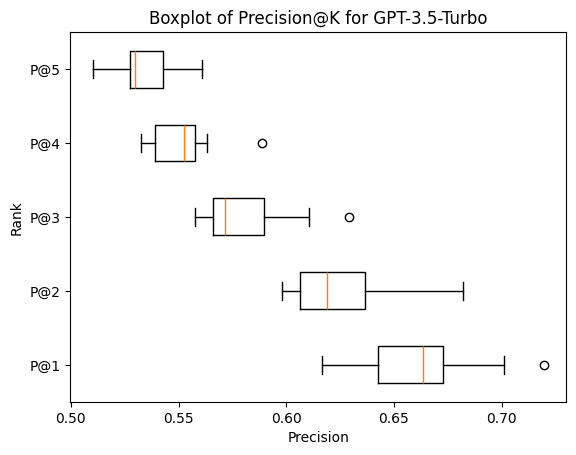

In [28]:
# TokenSplitter set up as ARAGOG paper
# Precision at 1: 0.9252336448598131
# Precision at 2: 0.9158878504672897
# Precision at 3: 0.8909657320872274
# Precision at 4: 0.8878504672897196
# Precision at 5: 0.8803738317757009
# [0.9252336448598131, 0.9158878504672897, 0.8909657320872274, 0.8878504672897196, 0.8803738317757009]

# Precision at 1: 0.9158878504672897
# Precision at 2: 0.9158878504672897
# Precision at 3: 0.8847352024922119
# Precision at 4: 0.8785046728971962
# Precision at 5: 0.8710280373831776
# [0.9158878504672897, 0.9158878504672897, 0.8847352024922119, 0.8785046728971962, 0.8710280373831776]

# Precision at 1: 0.9065420560747663
# Precision at 2: 0.8925233644859814
# Precision at 3: 0.881619937694704
# Precision at 4: 0.8714953271028038
# Precision at 5: 0.8710280373831776
# [0.9065420560747663, 0.8925233644859814, 0.881619937694704, 0.8714953271028038, 0.8710280373831776]

# trial_1 = [0.9252336448598131, 0.9158878504672897, 0.8909657320872274, 0.8878504672897196, 0.8803738317757009]
# trial_2 = [0.9158878504672897, 0.9158878504672897, 0.8847352024922119, 0.8785046728971962, 0.8710280373831776]
# trial_3 = [0.9065420560747663, 0.8925233644859814, 0.881619937694704, 0.8714953271028038, 0.8710280373831776]
# trial_4 = [0.9065420560747663, 0.897196261682243, 0.8847352024922117, 0.8761682242990654, 0.8654205607476636]
# trial_5 = [0.9345794392523364, 0.9345794392523364, 0.9127725856697819, 0.8925233644859814, 0.885981308411215]
# trial_6 = [0.9065420560747663, 0.8925233644859814, 0.8722741433021808, 0.866822429906542, 0.8616822429906541]
# trial_7 = [0.9065420560747663, 0.9065420560747663, 0.8909657320872274, 0.8785046728971962, 0.874766355140187]
# trial_8 = [0.9252336448598131, 0.9158878504672897, 0.8909657320872275, 0.883177570093458, 0.8766355140186914]


trial_1 = [0.6448598130841121, 0.6074766355140186, 0.557632398753894, 0.5537383177570093, 0.5457943925233645]
trial_2 = [0.7009345794392523, 0.6822429906542056, 0.6292834890965732, 0.5887850467289719, 0.5607476635514018]
trial_3 = [0.6635514018691588, 0.6308411214953271, 0.5825545171339565, 0.5514018691588785, 0.5308411214953271]
trial_4 = [0.6635514018691588, 0.6261682242990654, 0.5763239875389408, 0.5630841121495327, 0.5420560747663551]
trial_5 = [0.6635514018691588, 0.5981308411214953, 0.5669781931464173, 0.5373831775700935, 0.5289719626168224]
trial_6 = [0.616822429906542, 0.6121495327102804, 0.5638629283489096, 0.5397196261682243, 0.5233644859813082]
trial_7 = [0.719626168224299, 0.6542056074766355, 0.6105919003115265, 0.5560747663551402, 0.5289719626168223]
trial_8 = [0.6355140186915887, 0.602803738317757, 0.5669781931464175, 0.5327102803738317, 0.5102803738317757]

import matplotlib.pyplot as plt


# Create a list of all trials
all_trials = [trial_1, trial_2, trial_3, trial_4, trial_5, trial_6, trial_7, trial_8]

# Transpose the list to get precision at each rank
precision_at_each_rank = list(map(list, zip(*all_trials)))

# Create labels
labels = ['P@1', 'P@2', 'P@3', 'P@4', 'P@5']

# Create the boxplot
plt.boxplot(precision_at_each_rank, vert=False, labels=labels)
plt.title('Boxplot of Precision@K for GPT-3.5-Turbo')
plt.xlabel('Precision')
plt.ylabel('Rank')
plt.show()



In [ ]:
# Precision at 1: 0.9252336448598131
# Precision at 2: 0.9065420560747663
# Precision at 3: 0.9034267912772584
# Precision at 4: 0.8925233644859814
# Precision at 5: 0.8766355140186917

In [27]:
# TokenSplitter
# Precision at 1: 0.9065420560747663
# Precision at 2: 0.897196261682243
# Precision at 3: 0.8878504672897196
# Precision at 4: 0.8738317757009346
# Precision at 5: 0.8598130841121495

# RecursiveCharacterTextSplitter
# Precision at 1: 0.9252336448598131
# Precision at 2: 0.9065420560747663
# Precision at 3: 0.9034267912772584
# Precision at 4: 0.8925233644859814
# Precision at 5: 0.8766355140186917


percentage_change_1 = ((0.9252336448598131 - 0.9065420560747663) / 0.9065420560747663) * 100
percentage_change_2 = ((0.9065420560747663 - 0.897196261682243) / 0.897196261682243) * 100
percentage_change_3 = ((0.9034267912772584 - 0.8878504672897196) / 0.8878504672897196) * 100
percentage_change_4 = ((0.8925233644859814 - 0.8738317757009346) / 0.8738317757009346) * 100
percentage_change_5 = ((0.8766355140186917 - 0.8598130841121495) / 0.8598130841121495) * 100

print(f"Percentage Change 1: {percentage_change_1:.2f}%")
print(f"Percentage Change 2: {percentage_change_2:.2f}%")
print(f"Percentage Change 3: {percentage_change_3:.2f}%")
print(f"Percentage Change 4: {percentage_change_4:.2f}%")
print(f"Percentage Change 5: {percentage_change_5:.2f}%")


Percentage Change 1: 2.06%
Percentage Change 2: 1.04%
Percentage Change 3: 1.75%
Percentage Change 4: 2.14%
Percentage Change 5: 1.96%


Precision at 1: 0.9065420560747663
Precision at 2: 0.897196261682243
Precision at 3: 0.8878504672897196
Precision at 4: 0.8738317757009346
Precision at 5: 0.8598130841121495

# Hypothesis Test
Why is there variability? Does this come from documents its uncertain of or is it just hallucinations. 

In [1]:
import chromadb.utils.embedding_functions as embedding_functions
import chromadb
import os

chroma_client = chromadb.PersistentClient(path="../data/chroma_db")
OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=OPENAI_API_KEY,
                model_name="text-embedding-3-large"
            )
# The db below has chunks of 512 tokens and overlap of 50. Same as ARAGOG's setup. 
collection = chroma_client.get_collection("chuck_8", embedding_function=openai_ef)
collection.count()

import json
with open('../eval_questions/eval_data.json') as f:
    eval_data = json.load(f)
questions = eval_data['questions']

In [4]:
# num_tokens_from_string()
results = collection.query(query_texts=questions, n_results=1)

In [6]:
import backoff
import time
import numpy as np

@backoff.on_exception(backoff.expo,
                      Exception,  # Broadly catching all exceptions
                      max_tries=8)
def get_retrieval_precision_indicator_backoff(question, context, four=True):
    return get_retrieval_precision_indicator(question, context, four)

def get_questions_block():
    outcomes = np.zeros((len(questions), 5))
    # for i, question in enumerate(questions):
    for i, question in enumerate(questions):
        for j in range(5):
            outcomes[i][j] = get_retrieval_precision_indicator_backoff(question, results['documents'][i][0])
        print(f"Question {i}, Context {j}: {outcomes[i][j]}")
    return outcomes

from concurrent.futures import ThreadPoolExecutor
def execute_threads(num_tasks):
    with ThreadPoolExecutor(max_workers=num_tasks) as executor:
        futures = [executor.submit(get_questions_block) for _ in range(num_tasks)]
        return [future.result() for future in futures]

question_blocks = execute_threads(4)
final_outcomes = np.concatenate(question_blocks, axis=1)


Question 0, Context 4: 1.0
Question 0, Context 4: 1.0
Question 0, Context 4: 1.0
Question 0, Context 4: 1.0
Question 1, Context 4: 1.0
Question 1, Context 4: 1.0
Question 1, Context 4: 1.0
Question 1, Context 4: 1.0
Question 2, Context 4: 1.0
Question 2, Context 4: 1.0
Question 2, Context 4: 1.0
Question 3, Context 4: 0.0
Question 2, Context 4: 1.0
Question 3, Context 4: 1.0
Question 3, Context 4: 0.0
Question 4, Context 4: 0.0
Question 3, Context 4: 0.0
Question 4, Context 4: 1.0
Question 4, Context 4: 0.0
Question 5, Context 4: 0.0
Question 5, Context 4: 0.0
Question 4, Context 4: 1.0
Question 5, Context 4: 0.0
Question 6, Context 4: 1.0
Question 6, Context 4: 1.0
Question 5, Context 4: 0.0
Question 6, Context 4: 1.0
Question 7, Context 4: 1.0
Question 7, Context 4: 1.0
Question 6, Context 4: 1.0
Question 7, Context 4: 0.0
Question 8, Context 4: 0.0
Question 8, Context 4: 0.0
Question 7, Context 4: 0.0
Question 8, Context 4: 0.0
Question 9, Context 4: 0.0
Question 9, Context 4: 0.0
Q

In [28]:
final_outcomes = np.concatenate(question_blocks, axis=1)

In [42]:
final_outcomes[3,:]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [39]:
final_outcomes.mean(axis=1)

array([1.  , 1.  , 1.  , 0.05, 1.  , 1.  , 1.  , 1.  , 1.  , 0.2 , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.2 , 1.  , 1.  , 0.65,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.8 , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 0.9 , 1.  , 1.  , 1.  , 1.  , 0.  , 1.  , 1.  , 1.  ,
       0.15, 1.  , 1.  , 1.  , 1.  , 0.95, 1.  , 1.  , 0.95, 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.  , 1.  , 1.  ,
       1.  , 1.  , 0.9 , 1.  , 1.  , 1.  , 1.  , 1.  , 0.95, 1.  , 1.  ,
       1.  , 1.  , 0.45, 0.95, 0.2 , 1.  , 1.  , 1.  ])

In [64]:
import numpy as np

def binary_entropy(data):
    # Ensure data consists only of 0s and 1s
    if not np.all((data == 0) | (data == 1)):
        raise ValueError("Data must consist only of binary values (0 and 1).")
    
    p = np.mean(data)  # Probability of 1
    if p == 0 or p == 1:
        return 0.  # Entropy is zero if all values are the same
    
    # Calculate entropy
    entropy = -p * np.log2(p) - (1 - p) * np.log2(1 - p)
    return entropy

def calculate_entropies(data_matrix):
    entropies = np.apply_along_axis(binary_entropy, 1, data_matrix)
    return entropies

# Example usage:
data_matrix = np.random.randint(0, 2, (5, 20))  # Generate a random binary matrix of shape [5, 20]
print(data_matrix.dtype)
entropies = calculate_entropies(data_matrix)
print("Entropies of each row:", entropies)


int64
Entropies of each row: [0.99277445 1.         0.93406806 0.93406806 0.97095059]


In [65]:
entropies = calculate_entropies(final_outcomes)
print("Entropies of each row:", entropies)

Entropies of each row: [0.         0.         0.         0.28639696 0.         0.
 0.         0.         0.         0.72192809 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.72192809 0.
 0.         0.93406806 0.         0.         0.         0.
 0.         0.         0.72192809 0.         0.         0.
 0.         0.         0.         0.46899559 0.         0.
 0.         0.         0.         0.         0.         0.
 0.6098403  0.         0.         0.         0.         0.28639696
 0.         0.         0.28639696 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.46899559 0.         0.         0.         0.         0.
 0.28639696 0.         0.

In [71]:
# Get the indices of the entropies sorted in descending order
indices_sorted_by_entropy = np.argsort(entropies)[::-1]
# print("Indices of rows sorted by entropy:", indices_sorted_by_entropy)

for index in indices_sorted_by_entropy:
    entropy_value = entropies[index]
    if entropy_value == 0:
        break
    print(f"Entropy value at index {index}: {entropy_value}")
    print(f"Question: {questions[index]}")
    print(f"Context: {results['documents'][index][0]}")



Entropy value at index 101: 0.9927744539878083
Question: What methodologies were employed in SuperGLUE to establish robust human baseline performances across its tasks?
Context:  and COPA, human performance is perfect. On three other tasks, it is
in the mid-to-high 90s. On the diagnostics, all models continue to lag signiﬁcantly behind humans.
Though all models obtain near perfect gender parity scores on Winogender, this is due to the fact that
they are obtaining accuracy near that of random guessing.
6 Conclusion
We present SuperGLUE, a new benchmark for evaluating general-purpose language understanding
systems. SuperGLUE updates the GLUE benchmark by identifying a new set of challenging NLU
tasks, as measured by the difference between human and machine baselines. The set of eight tasks in
our benchmark emphasizes diverse task formats and low-data training data tasks, with nearly half the
tasks having fewer than 1k examples and all but one of the tasks having fewer than 10k examples.


# Hypothesis Conclusion
Yes, uncertainty arises from specific queries and their contexts. These queries can either be difficult to understand or, even if clear, it may be challenging to determine whether the surrounding context aids in answering the question.

In [5]:
from openai import OpenAI

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')

client = OpenAI(api_key=OPENAI_API_KEY)

def call_gpt(question, context, four=True):
    completion = client.chat.completions.create(
        model="gpt-4-turbo" if four else "gpt-3.5-turbo",
        # messages=[
        #     {"role": "system", "content": get_retrieval_precision_prompt(question, context)},
        #     {"role": "user", "content": "Is this CONTEXT relavent?"}
        # ]
                messages=[
            {"role": "system", "content": "You are a helpful assistant. Respond using markdown."},
            {"role": "user", "content": get_retrieval_precision_prompt(question, context)}
        ]
    )
    return completion.choices[0].message.content.lower().strip() == 'true'

def get_retrieval_precision_indicator(question, context, four=True):
    result1 = call_gpt(question, context, four)
    if not result1:
        return 0
    result2 = call_gpt(question, context, four)
    return 1 if result2 and result1 else 0


In [3]:
import chromadb.utils.embedding_functions as embedding_functions
import chromadb
import os

chroma_client = chromadb.PersistentClient(path="../data/chroma_db")
OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=OPENAI_API_KEY,
                model_name="text-embedding-3-large"
            )

collection = chroma_client.get_collection("chuck_8", embedding_function=openai_ef)
collection.count()

import json
with open('../eval_questions/eval_data.json') as f:
    eval_data = json.load(f)
questions = eval_data['questions']

results = collection.query(query_texts=questions, n_results=3)

In [ ]:
results['documents'][0]

In [6]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def get_score_column(column):
    scores = []
    for i, question in enumerate(questions):
        context = results['documents'][i][column]
        scores.append(get_retrieval_precision_indicator(question, context, False))
        print(f"Question {i}")
    return scores

def get_scores_for_columns(columns):
    with ThreadPoolExecutor(max_workers=len(columns)) as executor:
        futures = [executor.submit(get_score_column, column) for column in columns]
        return np.array([future.result() for future in futures]).T

scores = get_scores_for_columns([0, 1, 2])

Question 0
Question 0
Question 0
Question 1
Question 1
Question 2
Question 2
Question 1
Question 3
Question 3
Question 4
Question 2
Question 4
Question 5
Question 5
Question 3
Question 6
Question 4
Question 6
Question 7
Question 7
Question 8
Question 8
Question 9
Question 5
Question 10
Question 9
Question 6
Question 11
Question 10
Question 7
Question 12
Question 13
Question 8
Question 14
Question 11
Question 9
Question 12
Question 15
Question 13
Question 10
Question 14
Question 11
Question 16
Question 15
Question 12
Question 17
Question 16
Question 18
Question 13
Question 17
Question 19
Question 18
Question 14
Question 20
Question 19
Question 15
Question 21
Question 20
Question 22
Question 21
Question 16
Question 22
Question 17
Question 23
Question 23
Question 18
Question 24
Question 19
Question 24
Question 25
Question 26
Question 20
Question 25
Question 27
Question 21
Question 26
Question 28
Question 29
Question 22
Question 30
Question 27
Question 31
Question 28
Question 23
Question 3

In [7]:
print(scores.mean())
print(scores.mean(axis=0))

0.4143302180685358
[0.5046729  0.39252336 0.34579439]


In [134]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def get_score(question_group):
    scores = []
    for i, question in question_group:
        context = results['documents'][int(i)][0]
        scores.append(get_retrieval_precision_indicator(question, context))
        print(f"Question {i}")
    return scores

def get_scores(num_tasks):
    # Split questions into groups for each thread
    question_groups = np.array_split(list(enumerate(questions)), num_tasks)
    # print(question_groups)
    
    with ThreadPoolExecutor(max_workers=num_tasks) as executor:
        futures = [executor.submit(get_score, group) for group in question_groups]
        # Flatten the list of scores from each thread
        return np.concatenate([future.result() for future in futures])

scores = get_scores(4)


Question 54
Question 27
Question 0
Question 81
Question 55
Question 1
Question 82
Question 28
Question 56
Question 83
Question 2
Question 3
Question 29
Question 57
Question 4
Question 84
Question 30
Question 58
Question 85
Question 5
Question 31
Question 59
Question 32
Question 6
Question 60
Question 7
Question 33
Question 86
Question 61
Question 8
Question 34
Question 87
Question 62
Question 9
Question 63
Question 88
Question 35
Question 10
Question 36
Question 64
Question 89
Question 11
Question 37
Question 90
Question 12
Question 65
Question 38
Question 91
Question 66
Question 13
Question 92
Question 39
Question 14
Question 67
Question 93
Question 15
Question 94
Question 16
Question 40
Question 17
Question 95
Question 68
Question 41
Question 18
Question 96
Question 69
Question 42
Question 97
Question 19
Question 43
Question 70
Question 20
Question 71
Question 44
Question 98
Question 21
Question 72
Question 45
Question 22
Question 99
Question 73
Question 46
Question 23
Question 74
Qu

In [136]:
scores.mean() #0.916

0.9065420560747663

In [135]:
scores

array([1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

# Does Claude Score Similarly to GPT
Experiment on hold while re-directing focus to information density

In [139]:
import os
import anthropic

ANTHROPIC_API_KEY = os.getenv('ANTHROPIC_CHROMA_API_KEY')

client = anthropic.Anthropic(
    api_key=ANTHROPIC_API_KEY,
)

def call_gpt(question, context, four=True):
    completion = client.chat.completions.create(
        model="gpt-4-turbo" if four else "gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": get_retrieval_precision_prompt(question, context)},
            {"role": "user", "content": "Is this CONTEXT relavent?"}
        ]
    )
    return completion.choices[0].message.content.lower().strip() == 'true'

message = client.messages.create(
    model="claude-3-opus-20240229",
    max_tokens=1000,
    # temperature=0.0,
    system=get_retrieval_precision_prompt(question, context),
    messages=[
        {"role": "user", "content": "Is this CONTEXT relavent?"}
    ]
)

print(message.content)

[TextBlock(text='false', type='text')]


# Information Density of Retrieved Chunks

In [2]:
with open('../data/state_of_the_union.md', 'r') as file:
    data = file.read()
print(num_tokens_from_string(data))


Scoring system. Ideally you can seamlessly test this with ChromaDB. Equally you may want to deattach it so it just scores chunks. Hmmm. Exact text match?

In [7]:
def find_target_in_document(document, target):
    start_index = document.find(target)
    if start_index == -1:
        return None
    end_index = start_index + len(target)
    return start_index, end_index

def get_sub_string(document, start_index, end_index):
    return document[start_index:end_index]

In [48]:
find_target_in_document(data, "I left a law firm and became a public defender because my city of Wilmington was the only city in America occupied by the National Guard after Dr. King was assassinated because of the riots.")

(45662, 45852)

In [43]:
get_sub_string(data, 30405, 30668)

'But, look, if we change the dynamic at the border — people pay people — people pay these smugglers 8,000 bucks to get across the border because they know if they get by — if they get by and let into the country, it’s six to eight years before they have a hearing.'

In [10]:
question_and_ranges = [
    ("What specific actions did President Biden outline in his State of the Union address to address climate change and promote environmental justice by 2030?", (34465, 34820)),
    ("How much are people paying smugglers to get into the country?", (30405, 30668)),
    ("What is the term for the process where snack companies reduce the number of chips in a bag while keeping the size the same?", (26777, 26992)),
    ("What did Franklin Roosevelt say in the chamber in January 1941?", (141, 305)),
    ("Why did Biden leave a law firm and become a public defender?", (45662, 45852))
]

for question, (start, end) in question_and_ranges:
    print(f"Question: {question}")
    print(get_sub_string(data, start, end))
    print("\n\n")

Question: What specific actions did President Biden outline in his State of the Union address to address climate change and promote environmental justice by 2030?
I’m cutting our carbon emissions in half by 2030; creating tens of thousands of clean energy jobs, like the IBEW workers building and installing 500,000 electric vehicle charging stations; conserving 30 percent of America’s lands and waters by 2030; and taking action on environmental justice — fence-line communities smothered by the legacy of pollution.



Question: How much are people paying smugglers to get into the country?
But, look, if we change the dynamic at the border — people pay people — people pay these smugglers 8,000 bucks to get across the border because they know if they get by — if they get by and let into the country, it’s six to eight years before they have a hearing.



Question: What is the term for the process where snack companies reduce the number of chips in a bag while keeping the size the same?
In fa

In [55]:
from langchain_text_splitters import RecursiveCharacterTextSplitter, TokenTextSplitter


splitter = RecursiveCharacterTextSplitter(
    # chunk_size=1024,
    # chunk_overlap=256,
    chunk_size=400,
    chunk_overlap=200,
    length_function=num_tokens_from_string
)

# splitter = TokenTextSplitter(
#     encoding_name="cl100k_base",
#     chunk_size=400,
#     chunk_overlap=0,
# )

# Note that this will be incorrect if documents are identical
def get_chunks_and_metadata(splitter, corpus):
    documents = splitter.split_text(corpus)
    metadatas = []
    for document in documents:
        start_index, end_index = find_target_in_document(corpus, document)
        metadatas.append({"start_index": start_index, "end_index": end_index})
    return documents, metadatas

In [56]:
docs, metas = get_chunks_and_metadata(splitter, data)

In [65]:
total_tokens = 0
for i, doc in enumerate(docs):
    cur_tokens = num_tokens_from_string(doc)
    print(f"Index: {i}, Current tokens: {cur_tokens}")
    total_tokens += cur_tokens
print(f"Total tokens: {total_tokens}")

Index: 0, Current tokens: 378
Index: 1, Current tokens: 358
Index: 2, Current tokens: 369
Index: 3, Current tokens: 363
Index: 4, Current tokens: 372
Index: 5, Current tokens: 372
Index: 6, Current tokens: 384
Index: 7, Current tokens: 356
Index: 8, Current tokens: 373
Index: 9, Current tokens: 372
Index: 10, Current tokens: 389
Index: 11, Current tokens: 346
Index: 12, Current tokens: 361
Index: 13, Current tokens: 371
Index: 14, Current tokens: 374
Index: 15, Current tokens: 366
Index: 16, Current tokens: 340
Index: 17, Current tokens: 334
Index: 18, Current tokens: 379
Index: 19, Current tokens: 359
Index: 20, Current tokens: 360
Index: 21, Current tokens: 387
Index: 22, Current tokens: 361
Index: 23, Current tokens: 369
Index: 24, Current tokens: 385
Index: 25, Current tokens: 382
Index: 26, Current tokens: 381
Index: 27, Current tokens: 366
Index: 28, Current tokens: 363
Index: 29, Current tokens: 359
Index: 30, Current tokens: 386
Index: 31, Current tokens: 381
Index: 32, Current

In [62]:
import chromadb.utils.embedding_functions as embedding_functions
import chromadb
import os

chroma_client = chromadb.PersistentClient(path="../data/chroma_db")
OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
openai_ef = embedding_functions.OpenAIEmbeddingFunction(
                api_key=OPENAI_API_KEY,
                model_name="text-embedding-3-large"
            )

In [63]:
collection = chroma_client.create_collection("chuck_13", embedding_function=openai_ef)

In [66]:
collection.add(
    documents=docs,
    metadatas=metas,
    ids=[str(i) for i in range(len(docs))]
)

In [70]:
questions = [x[0] for x in question_and_ranges]
questions

['What specific actions did President Biden outline in his State of the Union address to address climate change and promote environmental justice by 2030?',
 'How much are people paying smugglers to get into the country?',
 'What is the term for the process where snack companies reduce the number of chips in a bag while keeping the size the same?',
 'What did Franklin Roosevelt say in the chamber in January 1941?',
 'Why did Biden leave a law firm and become a public defender?']

In [82]:
# Score model
import numpy as np
questions = [x[0] for x in question_and_ranges]
retrievals = collection.query(query_texts=questions, n_results=5)

def get_document_overlap_ratio(document_start, document_end, target_start, target_end):
    return max(0, min(document_end, target_end) - max(document_start, target_start))/(document_end - document_start)

score_block = np.zeros((len(questions), 5))

In [83]:
for question_index, (question, metadatas) in enumerate(zip(questions, retrievals['metadatas'])):
    for retrieval_index, metadata in enumerate(metadatas):
        start_index = metadata['start_index']
        end_index = metadata['end_index']
        question_start_index = question_and_ranges[question_index][1][0]
        question_end_index = question_and_ranges[question_index][1][1]

        score = get_document_overlap_ratio(start_index, end_index, question_start_index, question_end_index)
        score_block[question_index][retrieval_index] = score

In [84]:
print(score_block)

[[0.21244764 0.         0.         0.         0.        ]
 [0.18365922 0.1854725  0.         0.         0.        ]
 [0.12889688 0.13764405 0.         0.         0.        ]
 [0.09187675 0.         0.         0.         0.        ]
 [0.11289364 0.         0.         0.         0.        ]]


In [88]:
score_block.mean(axis=0)[0]

0.14595482590456144

In [ ]:
print(retrievals['ids'][1][0])
print(retrievals['documents'][1][0])

In [ ]:
print(retrievals['ids'][1][1])
print(retrievals['documents'][1][1])

# Pondering Thoughts About the Ideal Metric
## 1. Assume we have a perfect retriever.
A prefect retriever will return every chunk that contains ANY labelled information for a given query and only such chunks.
## 2. Our metric should be continuous, no discrete jumps.
If a chunking method is slightly better or worse, it should perform slightly better or worse.
## 3. There will be information overlap but probably less than 20% of case.
"John bought a new BMW. It had a top speed of 180MPH!\". To answer \"What make is John's car?\" you need \"John bought a new BMW\". To answer \"What's the top speed of John's car?\" you need the whole \"John bought a new BMW. It had a top speed of 180MPH!\". In this case, information is entangled and cannot be seperated.
## 4. We don't need questions. (They're a useful intermediary).
We look at our corupus and highlight some text. From this we generate a question. The question is therefore just to highlight some chunk of knowledge. Ideally, we'd generate all possible questions the corpus could answer. 

# Metric Second Iteration:
## Procedure:
1. Chunk text. We actually just want to know the start and end index of each chunk. So for each chunk we have 2 integers.
2. Iterate through each question.
3. For each question, there are highlighted parts in the text that answer it. Each of these highlights have a start and end index. 
4. 

In [2]:
import pandas as pd

# Note that this will be incorrect if documents are identical
def get_document_df(splitter, corpus):
    documents = splitter.split_text(corpus)
    start_indices = []
    end_indices = []
    for document in documents:
        start_index, end_index = find_target_in_document(corpus, document)
        start_indices.append(start_index)
        end_indices.append(end_index)
    return pd.DataFrame(data={'document': documents, 
                            'start_index': start_indices, 
                            'end_index': end_indices})


In [11]:
from langchain_text_splitters import RecursiveCharacterTextSplitter, TokenTextSplitter

splitter = RecursiveCharacterTextSplitter(
    # chunk_size=1024,
    # chunk_overlap=256,
    chunk_size=400,
    chunk_overlap=200,
    length_function=num_tokens_from_string
)

# splitter = TokenTextSplitter(
#     encoding_name="cl100k_base",
#     chunk_size=400,
#     chunk_overlap=0,
# )

document_df = get_document_df(splitter, data)

In [12]:
document_df.head()

,document,start_index,end_index
0,"Good evening. Good evening. If I were smart, I...",0,1785
1,What makes our moment rare is that freedom and...,910,2589
2,"Now — now my predecessor, a former Republican ...",1787,3484
3,"If the United States walks away, it will put U...",2743,4399
4,But they failed. America stood — America stood...,3634,5386


In [ ]:
# Score model
import numpy as np
questions = [x[0] for x in question_and_ranges]
retrievals = collection.query(query_texts=questions, n_results=5)

def get_document_overlap_ratio(document_start, document_end, target_start, target_end):
    return max(0, min(document_end, target_end) - max(document_start, target_start))/(document_end - document_start)

score_block = np.zeros((len(questions), 5))

for i, question in enumerate(questions):
    document_df[question] = document_df.apply(lambda row: get_document_overlap_ratio(row['start_index'], row['end_index'], question_and_ranges[i][1][0], question_and_ranges[i][1][1]), axis=1)


for question_index, (question, metadatas) in enumerate(zip(questions, retrievals['metadatas'])):
    for retrieval_index, metadata in enumerate(metadatas):
        start_index = metadata['start_index']
        end_index = metadata['end_index']
        question_start_index = question_and_ranges[question_index][1][0]
        question_end_index = question_and_ranges[question_index][1][1]

        score = get_document_overlap_ratio(start_index, end_index, question_start_index, question_end_index)
        score_block[question_index][retrieval_index] = score

# Zooming out
## Score Single Chunk Vs. Scoring All Chunks
In a sense, we're scoring all chunks with this metric. Since for a given question, we look at all chunks and grab the few that contain highlighted info. Perhaps what we really want is to score individual chunks. 

Ultimately you need to build something.

What is the most useful thing we can build right now?

It may be worth nonetheless pushing forward with our current metric.

Metric is built but we need a way to automate question making and highlighting process. 

One main problem. Everything is a sentence. A sentence level chunker always wins.

# Quick Experiments
Let's just try out some things based off intuition. 

## NxN Similarity Matrix

In [14]:
from langchain_text_splitters import RecursiveCharacterTextSplitter, TokenTextSplitter

splitter = RecursiveCharacterTextSplitter(
    # chunk_size=1024,
    # chunk_overlap=256,
    chunk_size=200,
    chunk_overlap=0,
    length_function=num_tokens_from_string
)

docs = splitter.split_text(data)

In [18]:
from openai import OpenAI
import os

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
client = OpenAI(api_key=OPENAI_API_KEY)

response = client.embeddings.create(
    input=docs,
    model="text-embedding-3-small"
)

In [28]:
import numpy as np

N = len(docs)

similarity_matrix = None
embedding_matrix = np.zeros((N, len(response.data[0].embedding)))

for i, embedding_obj in enumerate(response.data):
    embedding = np.array(embedding_obj.embedding)
    embedding_matrix[i] = embedding

similarity_matrix = np.dot(embedding_matrix, embedding_matrix.T)
    

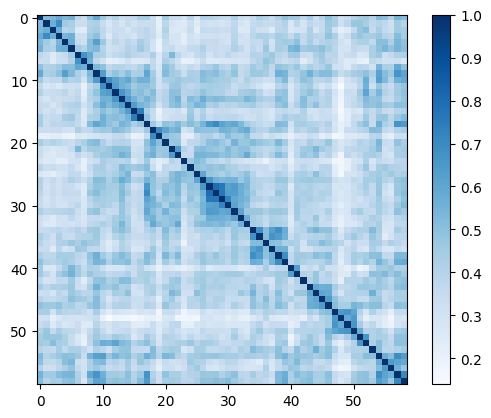

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Display the similarity matrix
plt.imshow(similarity_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.show()


In [34]:
import networkx as nx
import community as community_louvain

# Create a graph from the numpy array
G = nx.from_numpy_array(similarity_matrix)

# Use the Louvain method to find the best partition
partition = community_louvain.best_partition(G)

# Calculate the modularity based on this partition
modularity = community_louvain.modularity(partition, G)

print(f"The modularity of the partition is: {modularity}")

The modularity of the partition is: 0.09261886537347228


Well apparently this measures how connected this matrix is. The above score is from -1 to 1 so being near 0 means it's a little conncted but that's all. Hmmm. Will need to find a better metric and ideally one I can actually make quantitative comments on.

Returning to earlier metric:

The issue was that our assumption of a perfect retriever is unrealstic. 

Okay let's assume a semi-perfect retriever. Here we will actually perform a vector similarity search, however, of the 5 retrieved chunks we will take only those that contain highlighted text. This prevents the model from just breaking everything into sentences. 

In [14]:
from openai import OpenAI
import os
import json
import random

OPENAI_API_KEY = os.getenv('OPENAI_CHROMA_API_KEY')
client = OpenAI(api_key=OPENAI_API_KEY)

question_maker_prompt = """
Given the following text, extract significant facts and generate a question for each fact. Format your responses in JSON with a 'reference' field containing the text that answers the question, and a 'question' field containing a related question. Example:
Text: 'Neil Armstrong was the first person to walk on the moon during the Apollo 11 mission in 1969.'
Response: {
  'reference': 'Neil Armstrong was the first person to walk on the moon during the Apollo 11 mission in 1969.',
  'question': 'Who was the first person to walk on the moon and during which mission?'
}
"""

# 1800 characters because this is roughly under 400 tokens
def extract_question_and_reference(corpus, text_description, document_length=1800):
    if len(corpus) > document_length:
        start_index = random.randint(0, len(corpus) - document_length)
        document = corpus[start_index : start_index + document_length]
    else:
        document = corpus
    completion = client.chat.completions.create(
        model="gpt-4-turbo",
        response_format={ "type": "json_object" },
        max_tokens=500,
        messages=[
            {"role": "system", "content": question_maker_prompt},
            {"role": "user", "content": f"Text Description:{text_description}\n\nText: {document} \nRespond with a reference and question in JSON."}
        ]
    )
    
    json_response = json.loads(completion.choices[0].message.content)
    
    try:
        reference = json_response['reference']
    except KeyError:
        raise ValueError("The response does not contain a 'reference' field.")
    try:
        question = json_response['question']
    except KeyError:
        raise ValueError("The response does not contain a 'question' field.")

    target = find_target_in_document(corpus, reference)
    if target is None:
        raise ValueError("No match found in the document for the given reference.")
    else:
        start_index, end_index = target
    
    return question, reference, start_index, end_index

In [5]:
import pandas as pd

questions_df = pd.DataFrame(columns=['question', 'reference', 'start_index', 'end_index'])

In [22]:
new_rows = []

for i in range(20):
    while True:
        try:
            print(f"Trying Question {i}")
            question, reference, start_index, end_index = extract_question_and_reference(data, "This is a transcribed segment from President Biden's State of the Union Address.")
            new_rows.append({'question': question, 'reference': reference, 'start_index': start_index, 'end_index': end_index})
            break
        except (ValueError, json.JSONDecodeError) as e:
            print(f"Error occurred: {e}")
            continue
  
new_df = pd.DataFrame(new_rows, columns=questions_df.columns)
  
questions_df = pd.concat([questions_df, new_df])

Trying Question 0
Trying Question 1
Trying Question 2
Trying Question 3
Trying Question 4
Trying Question 5
Error occurred: No match found in the document for the given reference.
Trying Question 5
Trying Question 6
Trying Question 7
Trying Question 8
Trying Question 9
Trying Question 10
Trying Question 11
Trying Question 12
Trying Question 13
Trying Question 14
Error occurred: No match found in the document for the given reference.
Trying Question 14
Trying Question 15
Error occurred: No match found in the document for the given reference.
Trying Question 15
Trying Question 16
Trying Question 17
Trying Question 18
Error occurred: No match found in the document for the given reference.
Trying Question 18
Trying Question 19


In [24]:
questions_df.to_csv('../data/question_dataset.csv', index=False)


In [23]:
print(len(questions_df))

40


In [20]:
questions_df.tail()

,question,reference,start_index,end_index,index_difference
5,"According to President Biden's plan, what is t...","Under my plan, nobody earning less than $400,0...",23352,23477,NaN
6,Which group primarily benefited from the $2 tr...,The last administration enacted a $2 trillion ...,22747,22862,NaN
7,What does President Biden believe about the ma...,I believe that given the opportunity — for — a...,29359,29493,NaN
8,In which years did the proponents of reproduct...,"When reproductive freedom was on the ballot, w...",6948,7046,NaN
9,What has President Biden ensured regarding the...,"On my watch, federal projects that you fund — ...",10132,10338,NaN


In [25]:
questions_df['index_difference'] = questions_df['end_index'] - questions_df['start_index']
mean_difference = questions_df['index_difference'].mean()
print(f"The mean difference between start and end index is: {mean_difference}")


The mean difference between start and end index is: 137.3


<Axes: >

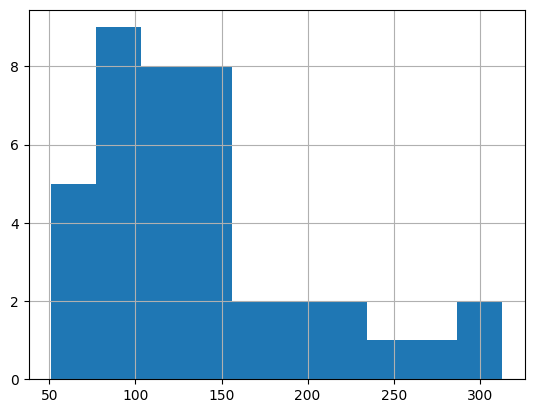

In [26]:
questions_df['index_difference'].hist()